In [56]:
import numpy as np
import matplotlib.pyplot as plt
from utils_3 import *
import sklearn
import sklearn.datasets
import scipy

plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

In [57]:
def load_dataset():
    data = scipy.io.loadmat('data/data.mat')
    X_train = data['X'].T
    Y_train = data['y'].T
    X_test = data['Xval'].T
    Y_test = data['yval'].T

    plt.scatter(X_train[0, :], X_train[1, :], c=np.squeeze(Y_train), s=40, cmap=plt.cm.Spectral);

    return X_train, Y_train, X_test, Y_test

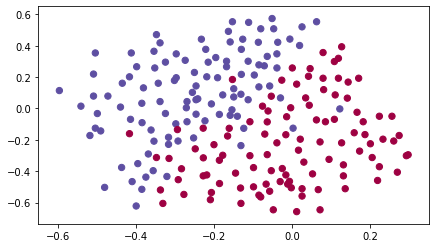

In [58]:
X_train, Y_train, X_test, Y_test = load_dataset()

# Non-regularized model

In [59]:
def model(X, Y, learning_rate=0.3, num_iter=30_000, print_cost=True, lambd = 0, keep_prob = 1):
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0], 20, 3, 1]
    
    params = init_params(layers_dims)
    
    for i in range(num_iter):
#         print("----------"+str(i))
        # FORWARD PROPAGATION
        if keep_prob == 1:
            A3, cache = forward_propagation(X, params)
        elif keep_prob < 1:
            A3, cache = forward_propagation_dropout(X, params, keep_prob)
        
        # COST FUNCTION
        if lambd == 0:
            cost = compute_cost(A3, Y)
        else:
            cost = compute_cost_regularization(A3, Y, params, lambd)
        
        if lambd == 0 and keep_prob == 1:
            grads = backprop(X, Y, cache)
        elif lambd != 0:
            grads = backprop_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backprop_dropout(X, Y, cache, keep_prob)
            
        params = update_params(params, grads, learning_rate)
        
        if i % 1000 == 0:
            costs.append(cost)
        if i % 10000 == 0 and print_cost:
            print("Cost after iteration {}: {}".format(i, cost))
    plt.plot(costs)
    plt.ylabel("cost")
    plt.title("Learning rate: {}".format(learning_rate))
    plt.show()
    
    return params

Cost after iteration 0: 0.6824848131199327
Cost after iteration 10000: 0.12113959524339366


R:\PYTHON\MLProjects\Scratch\utils_3.py:46: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(A3),Y) + np.multiply(-np.log(1 - A3), 1 - Y)
R:\PYTHON\MLProjects\Scratch\utils_3.py:46: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(A3),Y) + np.multiply(-np.log(1 - A3), 1 - Y)


Cost after iteration 20000: 0.06294701275710265


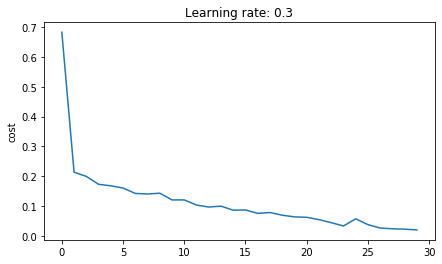

On the training set:
Accuracy: 1.0
On the test set:
Accuracy: 0.915


In [60]:
params = model(X_train, Y_train)
print ("On the training set:")
preds_train = predict(X_train, Y_train, params)
print ("On the test set:")
preds_test = predict(X_test, Y_test, params)

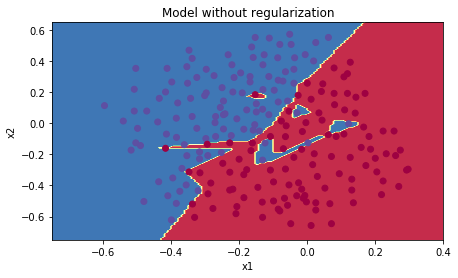

In [61]:
from utils import plot_decision_boundary
from utils_3 import predict_dec

plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(params, x.T), X_train, Y_train)

# L2 Regularization

The standard way to avoid overfitting is called L2 regularization. It consists of appropriately modifying your cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$


In [62]:
def compute_cost_regularization(A3, Y, params, lambd):
    m = Y.shape[1]
    W1 = params["W1"]
    W2 = params["W2"]
    W3 = params["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y)
    
    L2_regularization_cost = 1/m * lambd/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    
    cost = cross_entropy_cost + L2_regularization_cost
    return cost

In [63]:
def backprop_regularization(X, Y, cache, lambd):
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    m = X.shape[1]
    
    dZ3 = (A3 - Y)
    dW3 = 1/m * np.dot(dZ3, A2.T) + lambd/m * W3
    db3 = 1/m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1/m * np.dot(dZ2, A1.T) + lambd/m * W2
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1/m * np.dot(dZ1, X.T) + lambd/m * W1
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {
        "dZ3":dZ3, 'dW3':dW3, 'db3':db3,
        "dA2":dA2, "dZ2":dZ2, "dW2":dW2, "db2":db2,
        "dA1":dA1, "dZ1":dZ1, "dW1":dW1, "db1":db1
    }
    
    return grads

Cost after iteration 0: 0.7208939863480188
Cost after iteration 10000: 0.2675043185310642
Cost after iteration 20000: 0.2673071329038681


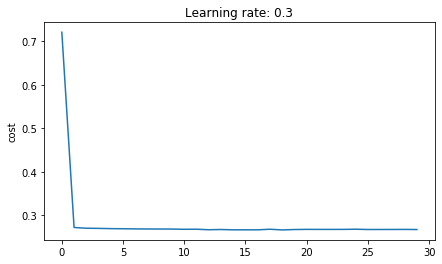

On the train set:
Accuracy: 0.933649289099526
On the test set:
Accuracy: 0.95


In [64]:
params = model(X_train, Y_train, lambd = 0.7)
print ("On the train set:")
preds_train = predict(X_train, Y_train, params)
print ("On the test set:")
preds_test = predict(X_test, Y_test, params)

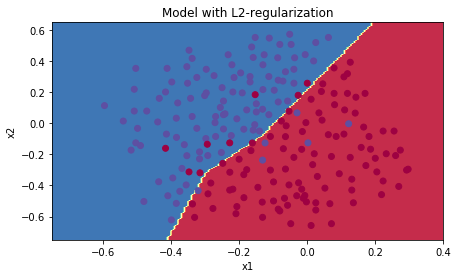

In [65]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(params, x.T), X_train, Y_train)

# Dropout (Forward Propagation)

In [66]:
def forward_propagation_dropout(X, params, keep_prob = 0.5):
    np.random.seed(1)
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    W3 = params["W3"]
    b3 = params["b3"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    D1 = np.random.randn(1, A1.shape[1])
    D1 = (D1 < keep_prob).astype(int)
    A1 = A1 * D1
    A1 = A1 / keep_prob
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    D2 = np.random.randn(1, A2.shape[1])
    D2 = (D2 < keep_prob).astype(int)
    A2 = A2 * D2
    A2 = A2 / keep_prob
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (
        Z1, D1, A1, W1, b1,
        Z2, D2, A2, W2, b2,
        Z3, A3, W3, b3
    )
    
    return A3, cache

In [67]:
def backprop_dropout(X, Y, cache, keep_prob):
    (Z1, D1, A1, W1, b1,
    Z2, D2, A2, W2, b2,
    Z3, A3, W3, b3) = cache
    
    m = X.shape[1]
    
    dZ3 = A3 - Y
    dW3 = 1/m * np.dot(dZ3, A2.T)
    db3 = 1/m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dA2 = np.multiply(dA2, D2)
    dA2 = dA2 / keep_prob
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = np.multiply(dA1, D1)
    dA1 = dA1 / keep_prob
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {
        "dZ3":dZ3, "dW3":dW3, "db3":db3,
        "dZ2":dZ2, "dA2":dA2, "dW2":dW2, "db2":db2,
        "dZ1":dZ1, "dA1":dA1, "dW1":dW1, "db1":db1
    }
    
    return grads

Cost after iteration 0: 0.7039518798530806
Cost after iteration 10000: 0.38586421057257836
Cost after iteration 20000: 0.3318683237350893


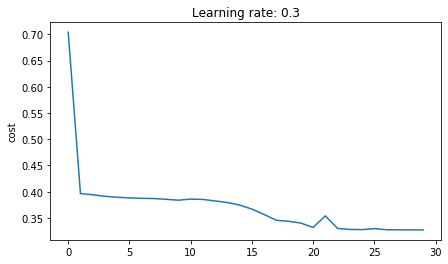

On the train set:
Accuracy: 0.957345971563981
On the test set:
Accuracy: 0.945


In [68]:
params = model(X_train, Y_train, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
preds_train = predict(X_train, Y_train, params)
print ("On the test set:")
preds_test = predict(X_test, Y_test, params)

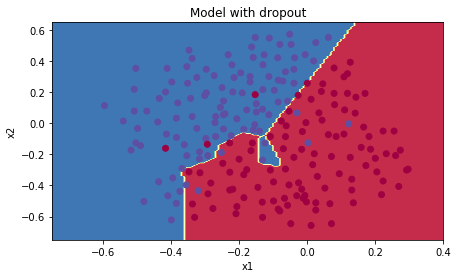

In [69]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(params, x.T), X_train, Y_train)

A common mistake when using dropout is to use it both in training and testing. You should use dropout (randomly eliminate nodes) only in training.